In [1]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [3]:
# Build a rangeplot!
def rangeplot(df, x, y, color=None):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

In [2]:
# import the data
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

# convert the date column to a datetime object
flights["time_hour"] = pd.to_datetime(flights["time_hour"])

# add a column for the day of the week
flights["dow"] = (
    flights["time_hour"]
    .dt.day_name()
    .str[:3]
    .astype("category")
    .cat.set_categories(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
)

# add a column for the season
flights["season"] = np.where(flights["month"].isin([6, 7]), "summer", "other month")

In [4]:
# filter out the flights to SFO
sfo = flights.query('dest == "SFO" & arr_delay < 500').copy()

# 기존 모델

In [5]:
from statsmodels.formula.api import ols
mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()

In [7]:
sfo["resid"] = mod.resid

# 좋은 모델인가? - 1
## 4시간동안의 트렌드 라인 확인하니까 잔차가 앞과 뒤가 잔차가 크게 나온다. 우리 모델이 뭔가 패턴을 잡지 못하고 있다. 시간에 따른 delay가 잘 안 잡힌다고 봐야 된다.
## 3시 이후부터인 오후 시간에는 왜 안 잡힐까?? —> mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()와 같은 우리 식에서는 hour이 arr_delay가 일자로 선형적으로 쭉 늘어난다고 가정을 하니까, 잔차가 저렇게 되는 이유는 선형 관계가 아니기 떄문에.  

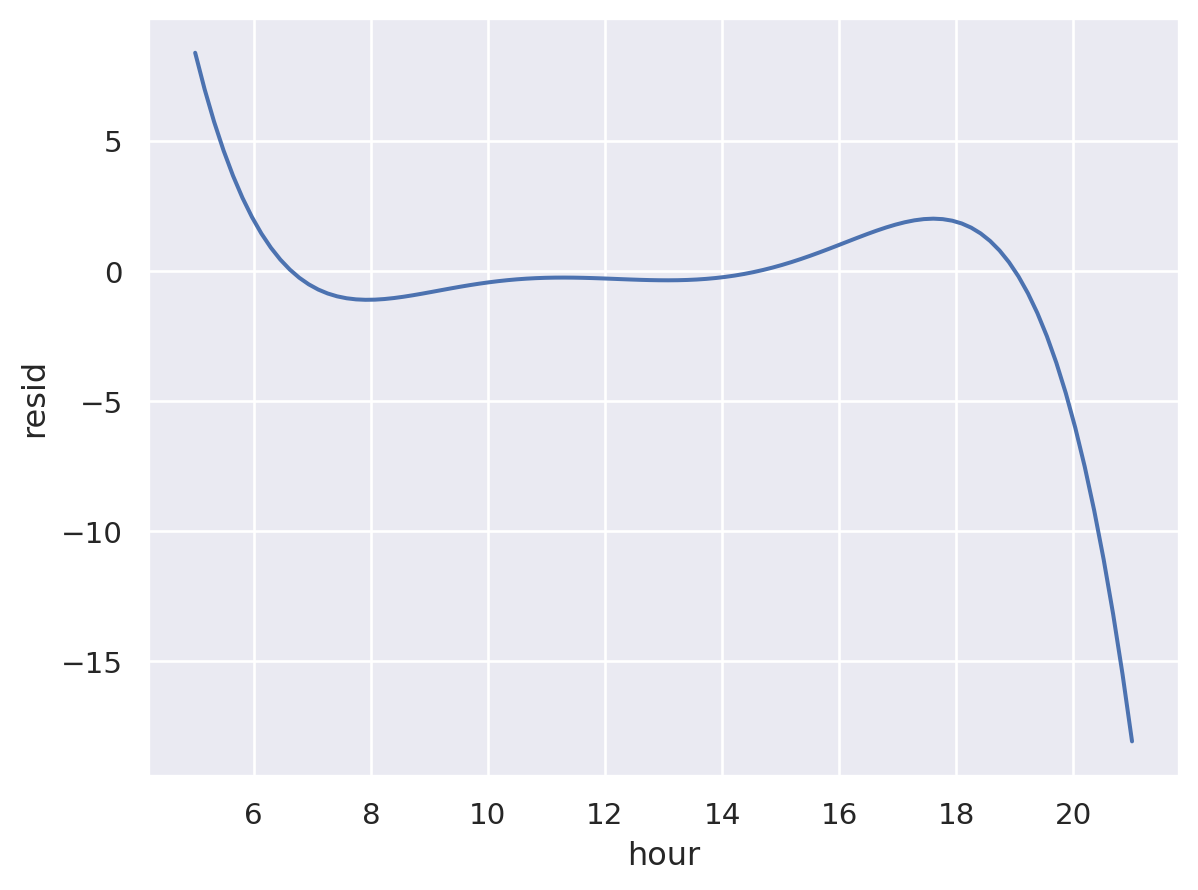

In [8]:
(
    so.Plot(sfo, x='hour', y='resid')
    #.add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
)

# 좋은 모델인가? - 2
## 여름 잔차와 다른 날의 잔차가 다르다. —> season을 넣어줬음에도 생각보다 효과가 덜하다.

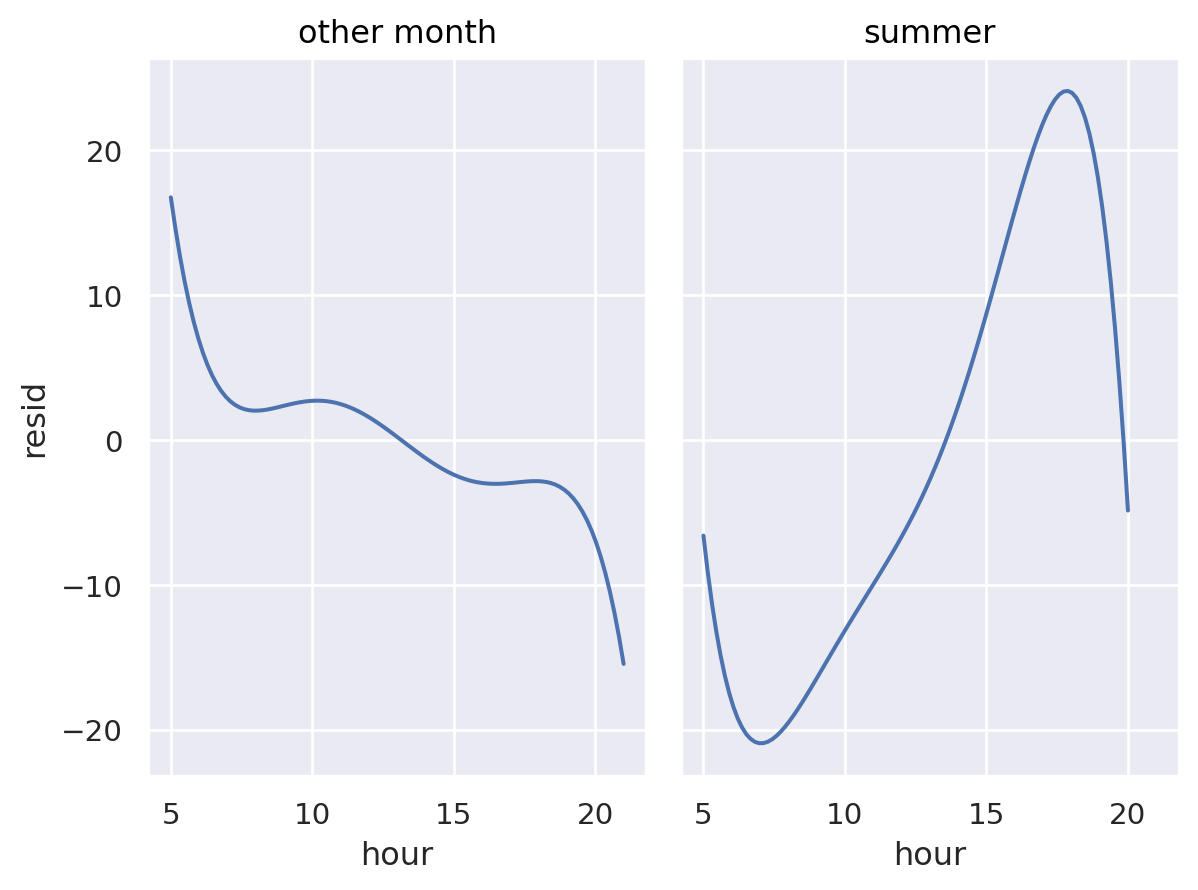

In [9]:
(
    so.Plot(sfo, x='hour', y='resid')
    .add(so.Line(), so.PolyFit(5))
    .facet("season")
)

# 요일별로 확인해보니까 요일별로 패턴이 달라보이냐? —> 뭐 그렇게 크게 달라보이지는 않는다고 정성적 평가

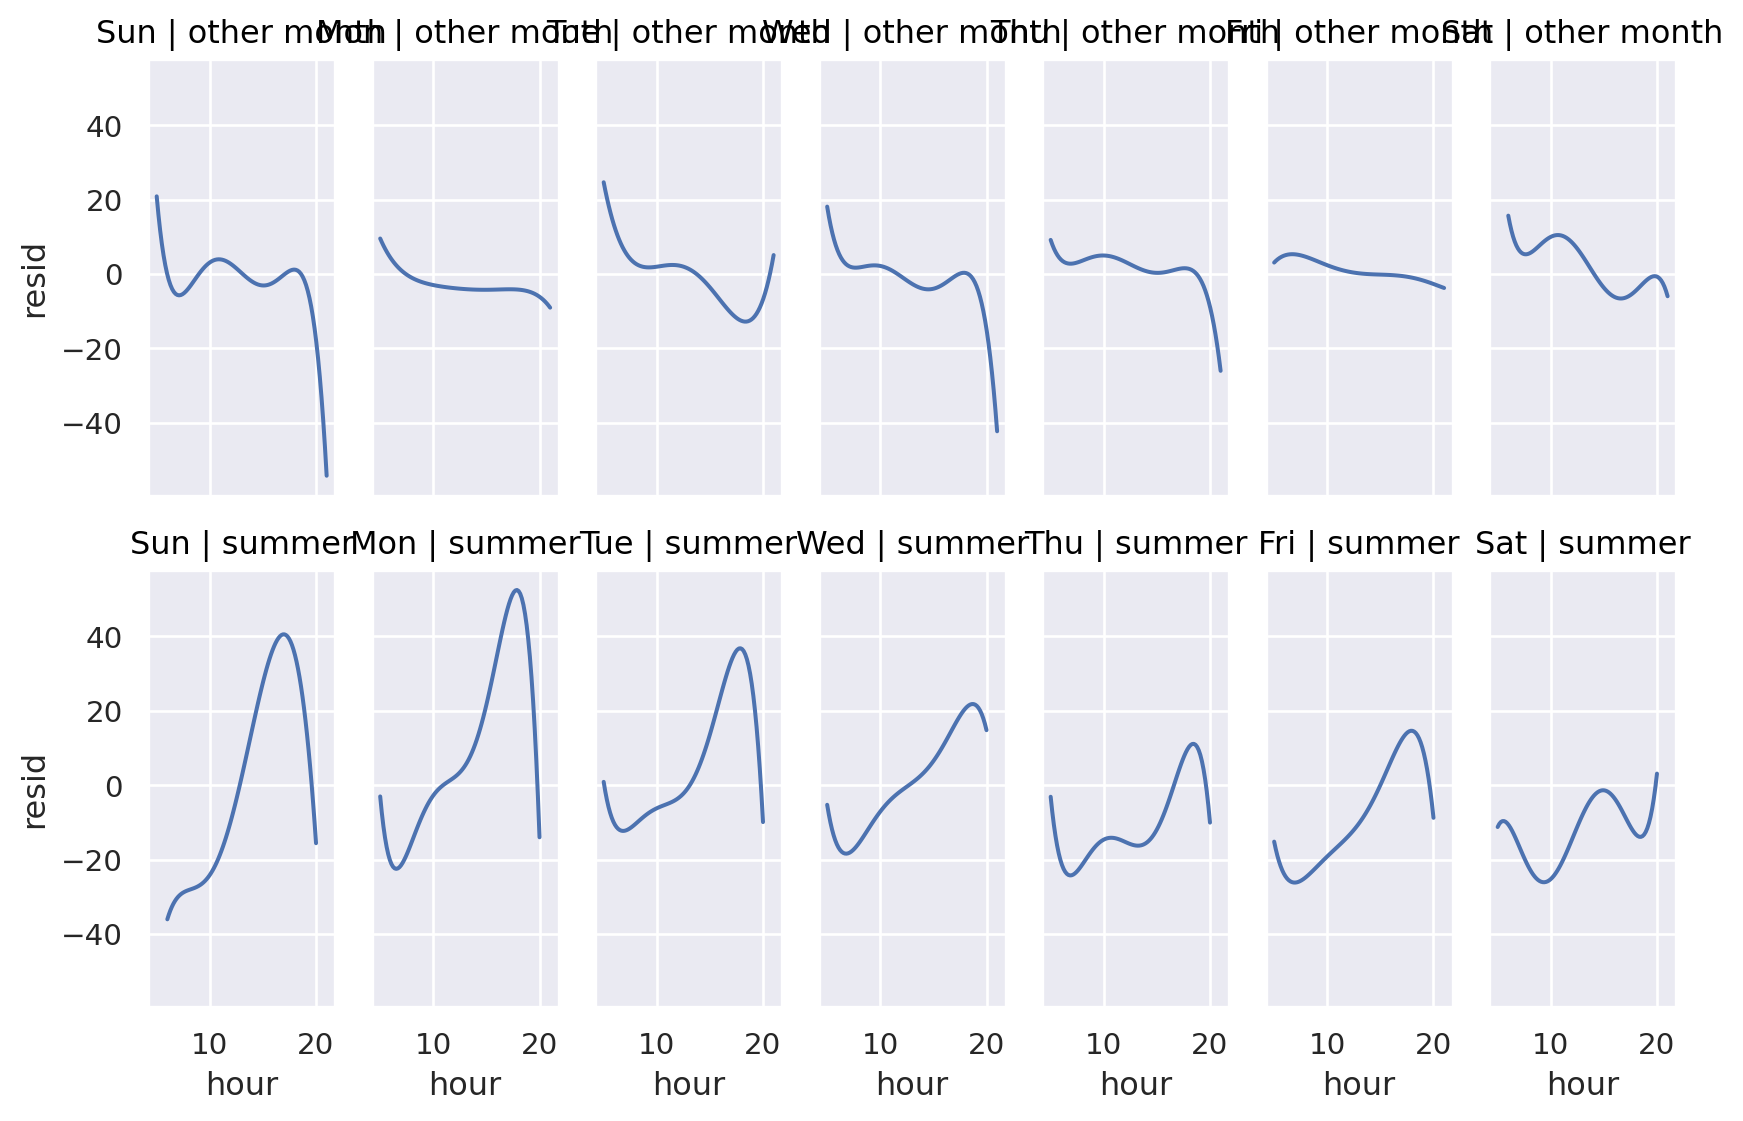

In [12]:
(
    so.Plot(sfo, x='hour', y='resid')
    .add(so.Line(), so.PolyFit(5))
    .facet(row="season", col="dow")
    .layout(size=(9, 6))
)

# 8시부터 16시는 선형이라고 볼 수 있는데, 앞에 있는 게 딜레이가 되어서 18시 이후가 딜레이된다. 전체가 선형이 아니므로 어떻게 세울 것인가? —> 3차 함수로 세운다.

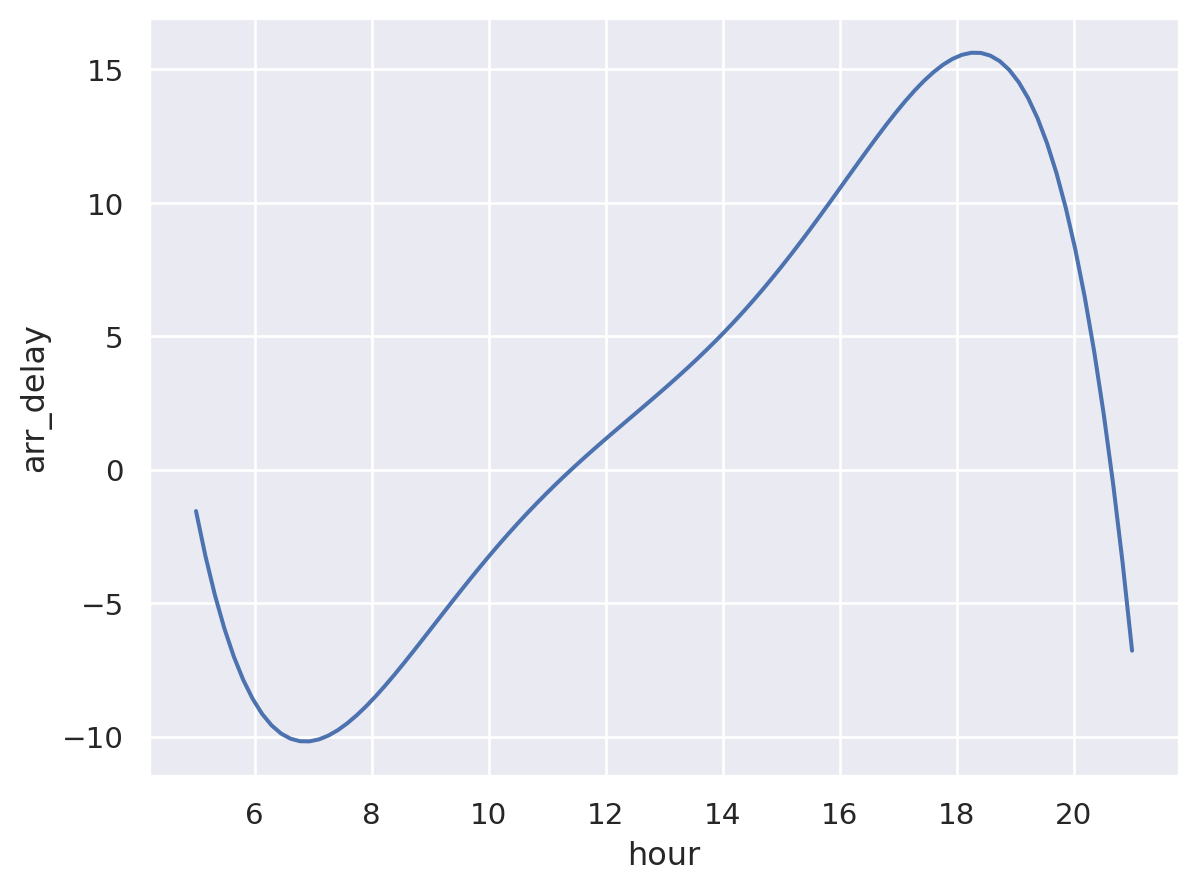

In [11]:
(
    so.Plot(sfo, x='hour', y='arr_delay')
    #.add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
)

# 요일별로도 볼 수 있을 거 같다.

In [ ]:
(
    so.Plot(sfo, x='hour', y='arr_delay')
    #.add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .facet("dow")
    .layout(size=(9, 4))
)

# 6,7월이 다른 것과 패턴이 다르므로 6,7월 빼고 나머지를 다른 달로 묶든지 할 수 있다

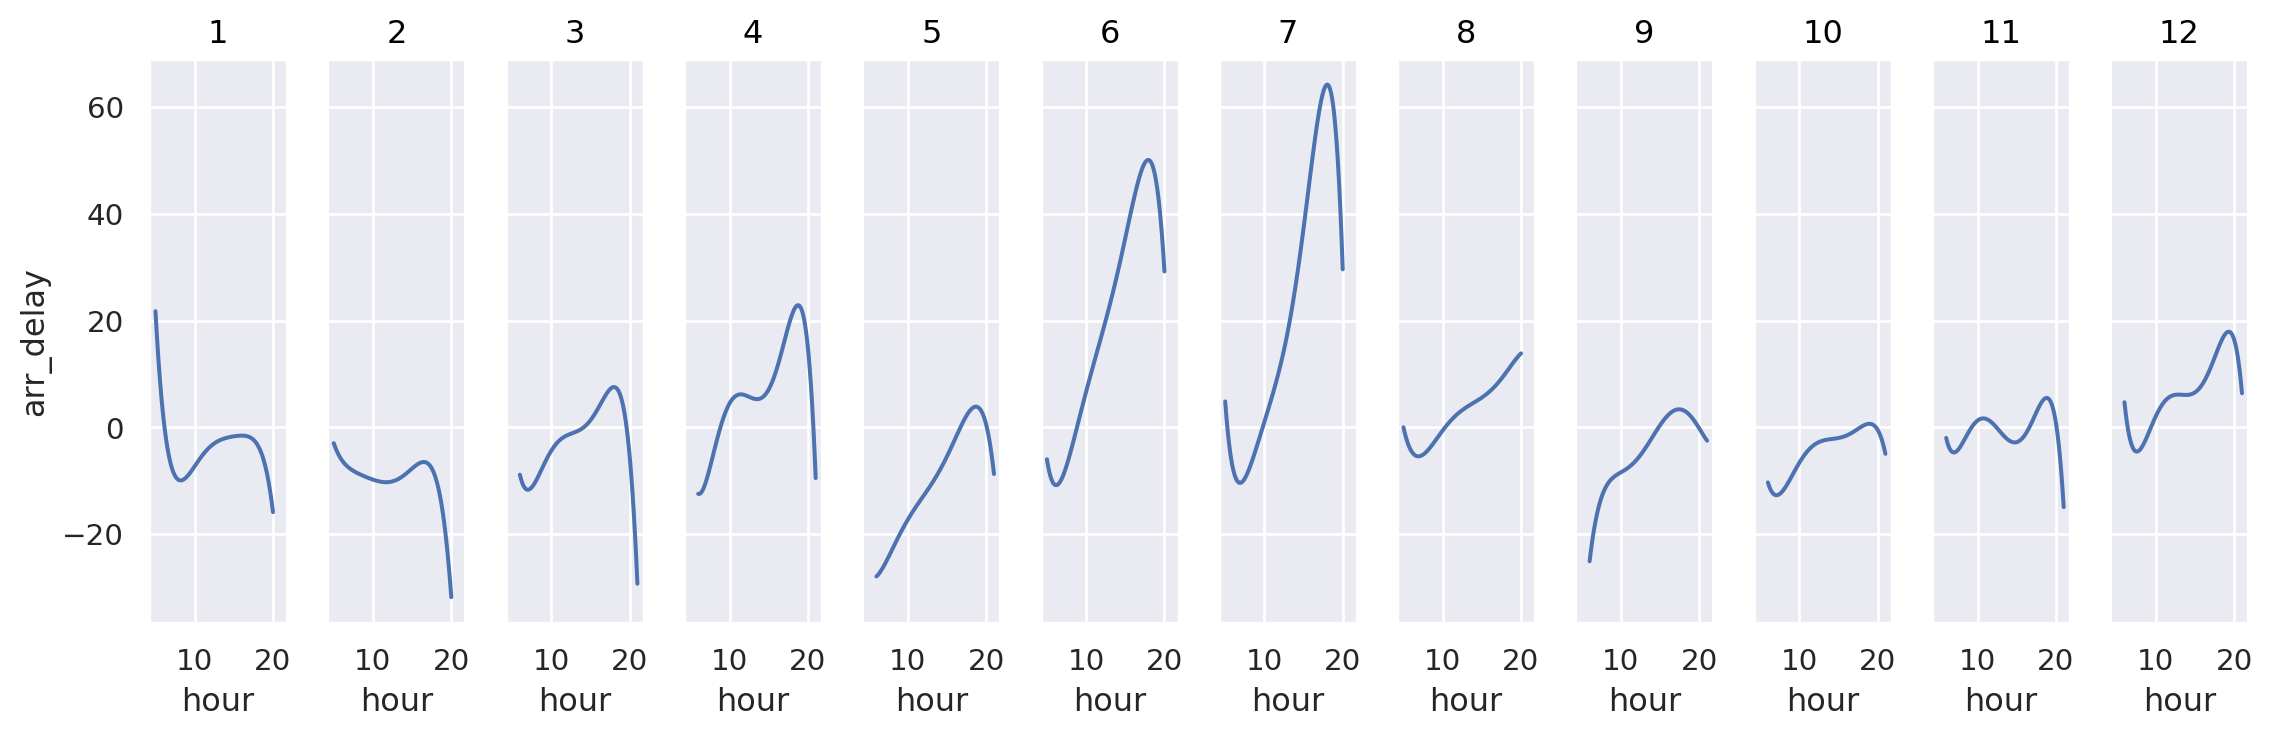

In [10]:
(
    so.Plot(sfo, x='hour', y='arr_delay')
    #.add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .facet("month")
    .layout(size=(12, 4))
)

# 공항 출발지 따라서는 큰 차이가 없을 것이라고 볼 수 있다.

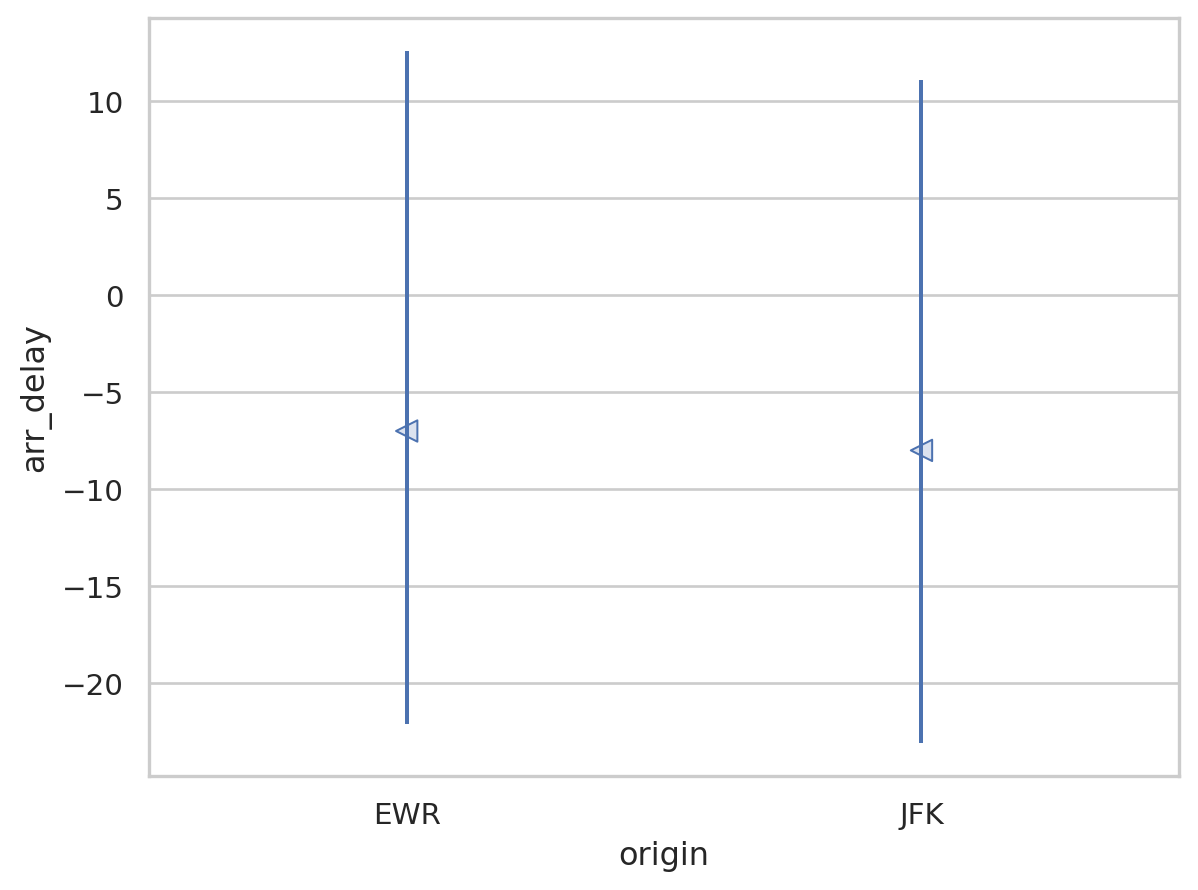

In [13]:
rangeplot(sfo, x='origin', y='arr_delay')

# carrier를 보면 항공사마다 조금 차이가 난다고 볼 수 있다.

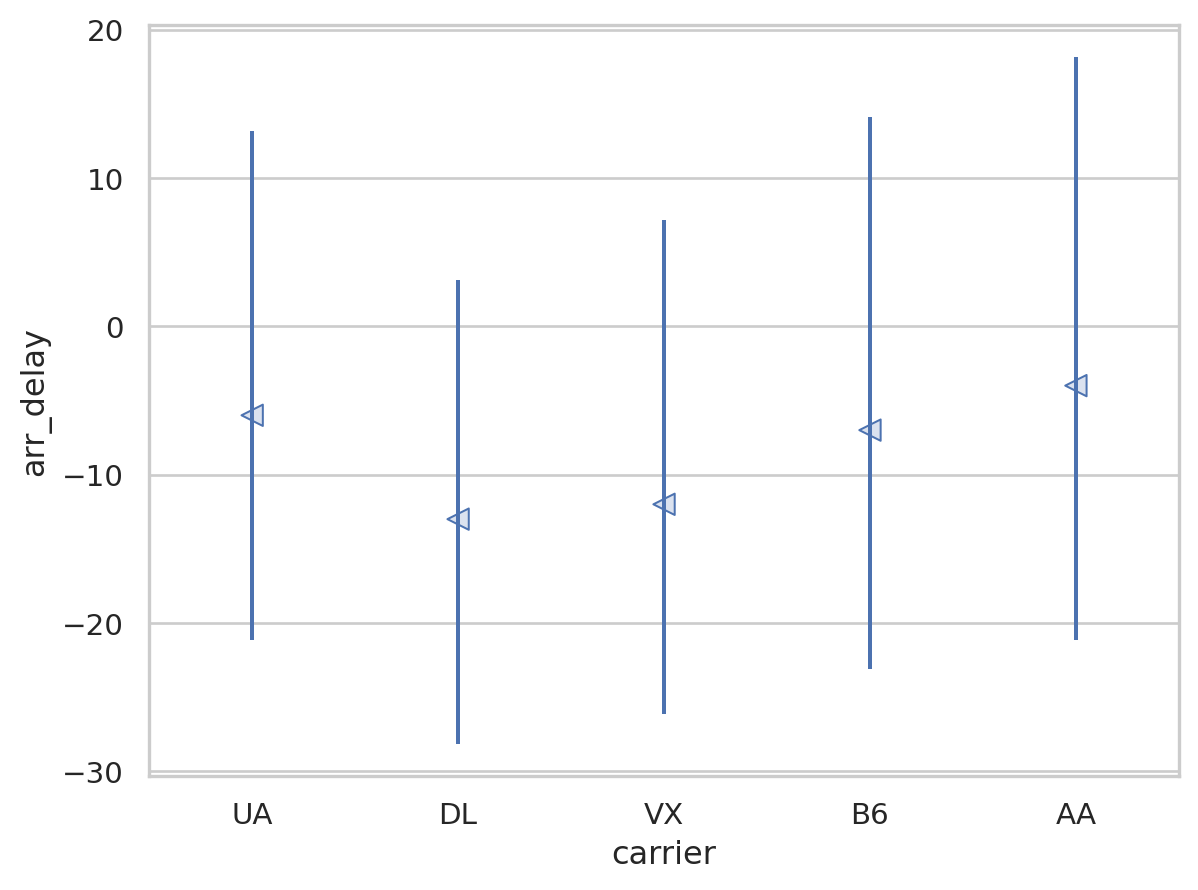

In [14]:
rangeplot(sfo, x='carrier', y='arr_delay')

# 모델 비교 0, 1, 2
## 첫번쨰는 저자가 세운 모형, 두번쨰는 origin을 뺸, 세번쨰는 추가로 carrier도 뺀 모형
## R-squared를 비교해보면 거의 영향력이 없다. R-squared 차이가 없다. origin이 arr_delay에 설명하는 것이 거의 없다고 해석 가능. 차이값에서 carrier는 더 설명한다는 걸 걸 입증.

In [15]:
mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()

# origin removed
mod1 = ols("arr_delay ~ hour + carrier + season + dow", data=sfo).fit()

# carrier removed
mod2 = ols("arr_delay ~ hour + season + dow", data=sfo).fit()

print(f"R-squared: {mod.rsquared:.3f}, {mod1.rsquared:.3f}, {mod2.rsquared:.3f}")

R-squared: 0.096, 0.094, 0.084


# 모델 비교 3, 4, 5
## arr_delay ~ hour * season 상호작용의 뜻: hour가 arr_delay 간 관계가 있는데 그걸 season이 바꾼다고 생각하면 됨, season은 6,7월과 나머지 달 상호작용한다고 생각. month는 모든 달이 hour가 상호작용한다고 가정.
## month를 hour 별로 봤을 때 패턴이 확실히 다르다고 가정했을 때, 이 2개를 상호작용한다고 할 수 있고, hour * C(month) 이렇게 한다.
## month 11개 , dow 6개 = 변수 개수가 66개
## adjusted r-squared: 내가 얻은 r-squared 값보다는 설명이 작을 거라고 여거서 보정을 한다

In [16]:
# hour와 season이 상호작용하는 것으로 가정
mod3 = ols("arr_delay ~ hour * season + origin + carrier + dow", data=sfo).fit()

# hour와 모든 달과 상호작용하는 것으로 가정
mod4 = ols("arr_delay ~ hour * C(month) + origin + carrier + dow", data=sfo).fit()  # C(month) : month를 범주형 변수로 취급

# hour, 모든 달, 요일이 서로 상호작용하는 것으로 가정
mod5 = ols("arr_delay ~ hour * C(month) * dow + origin + carrier", data=sfo).fit()  # C(month) : month를 범주형 변수로 취급

print(f"R-squared: {mod.rsquared:.3f}, {mod3.rsquared:.3f}, {mod4.rsquared:.3f}, {mod5.rsquared:.3f}")

R-squared: 0.096, 0.118, 0.136, 0.177


In [17]:
print(mod5.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     16.25
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        09:57:31   Log-Likelihood:                -67798.
No. Observations:               13169   AIC:                         1.359e+05
Df Residuals:                   12996   BIC:                         1.372e+05
Df Model:                         172                                         
Covariance Type:            nonrobust                                         
